# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. <br> 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Неоходимо построить модель, которая по фотографии определит приблизительный возраст человека. <br>

В нашем распоряжении набор фотографий людей с указанием возраста.<br>

В ходе проекта мы:
1.	Проведем исследовательский анализ набора фотографий
2.	Подготовим данные к обучению
3.	Обучим нейронную сеть и рассчитаем её качество



Описание данных<br>
- данные взяты с сайта ChaLearn Looking at People и находятся в папке `/datasets/faces/`
- папка со всеми изображениями `/final_files` 
- csv-файл `labels.csv` с двумя колонками: `file_name` и `real_age`
______________________________

Приступим, сделаем импорт необходимых библиотек и изучим входные данные.

In [1]:
import numpy as np
import pandas as pd

from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D

In [2]:
def plot_info_on_numerical_column( _df, 
                                   _feature_title,
                                   _text_info = True,
                                   _bins = 50, 
                                   _figure_width = 20, 
                                   _figure_height = 12, 
                                   _fontsize=15,
                                   _number_of_decimals = 2):

    NCOLS_NUMBER_CONST = 2
    
    fig, ax = plt.subplots(ncols=NCOLS_NUMBER_CONST, figsize=(_figure_width, _figure_height))

    sns.histplot(data=_df, 
                 x=_feature_title, 
                 color="cornflowerblue", 
                 label=_feature_title, 
                 bins=_bins, 
                 kde=True,
                 ax=ax[0])
        
    mean_value = _df[_feature_title].mean()  
    median_value = _df[_feature_title].median() 
    
    ax[0].axvline(x=mean_value, color='black', lw = 2, ls = ':', 
                  label = "mean: {}".format(round(mean_value, _number_of_decimals)))
    ax[0].axvline(x=median_value, color='blue', lw = 2, ls = '-.', 
                  label = "median: {}".format(round(median_value, _number_of_decimals)))

    ax[0].legend(fontsize = '15', title_fontsize = "10", loc='upper right') 
        
    plt.tight_layout()
    
    Q1_QUANTILE_VALUE_CONST = float(0.25)
    Q3_QUANTILE_VALUE_CONST = float(0.75)
    IQR_MULT_DEFAULT_CONST = float(1.5)
    
    Q1 = _df[_feature_title].quantile(Q1_QUANTILE_VALUE_CONST)
    Q3 = _df[_feature_title].quantile(Q3_QUANTILE_VALUE_CONST)
    IQR = Q3 - Q1 

            
    outliers_low_bound = Q1 - IQR_MULT_DEFAULT_CONST*IQR
    outliers_upper_bound = Q3 + IQR_MULT_DEFAULT_CONST*IQR      
    
    sns.boxplot(x=_df[_feature_title], color="cornflowerblue", ax=ax[1])

    if _text_info:
        print("Q1 == {:.2f}, Q3 == {:.2f}, IQR == {:.2f}".format(Q1, Q3, IQR))
        print("[Q1 - 1.5*IQR] == {:.2f}, [Q3 + 1.5*IQR] == {:.2f}".format(outliers_low_bound, outliers_upper_bound))    

    plt.show()

## Исследовательский анализ данных

In [3]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
df_labels['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

In [7]:
df_labels['real_age'].value_counts().tail(10)

78     3
81     3
83     3
88     3
95     2
96     2
93     1
100    1
91     1
97     1
Name: real_age, dtype: int64

Q1 == 20.00, Q3 == 41.00, IQR == 21.00
[Q1 - 1.5*IQR] == -11.50, [Q3 + 1.5*IQR] == 72.50


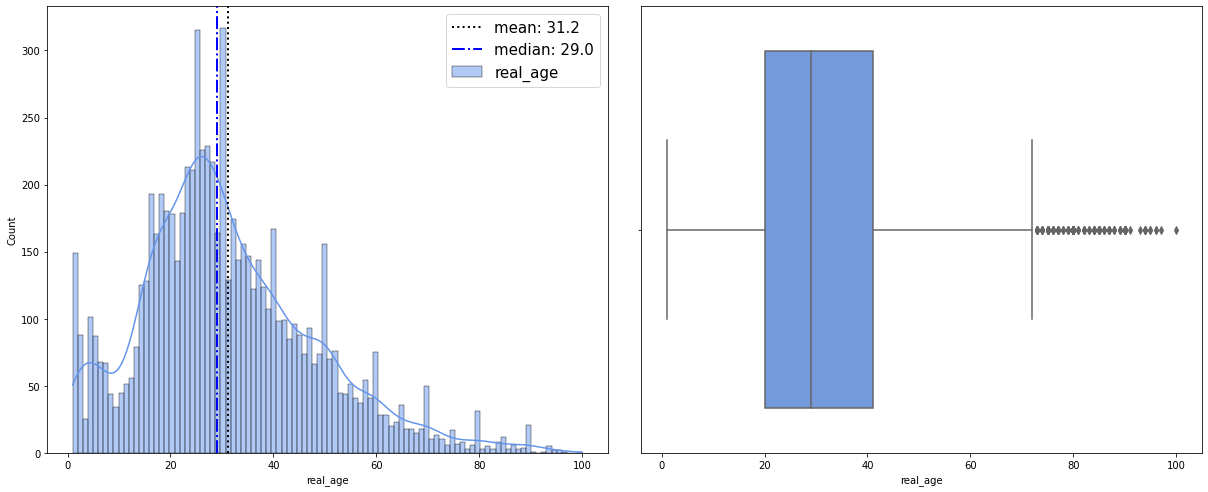

In [8]:
plot_info_on_numerical_column(df_labels, 'real_age', _bins=100, _figure_width = 17, _figure_height = 7)

In [9]:
RESCALE_VALUE_CONST = 1./255.0
SEED_VALUE_CONST = 424
BATCH_SIZE_VALUE_CONST = 16
TARGET_SIZE_VALUE_CONST = (224, 224)

images_dg = ImageDataGenerator(rescale=RESCALE_VALUE_CONST)

images_path = "/datasets/faces/final_files/"

images_gen_flow = images_dg.flow_from_dataframe(dataframe=df_labels,
                                                directory=images_path,
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=TARGET_SIZE_VALUE_CONST,
                                                batch_size=BATCH_SIZE_VALUE_CONST,
                                                class_mode='raw',
                                                seed=SEED_VALUE_CONST)

Found 7591 validated image filenames.


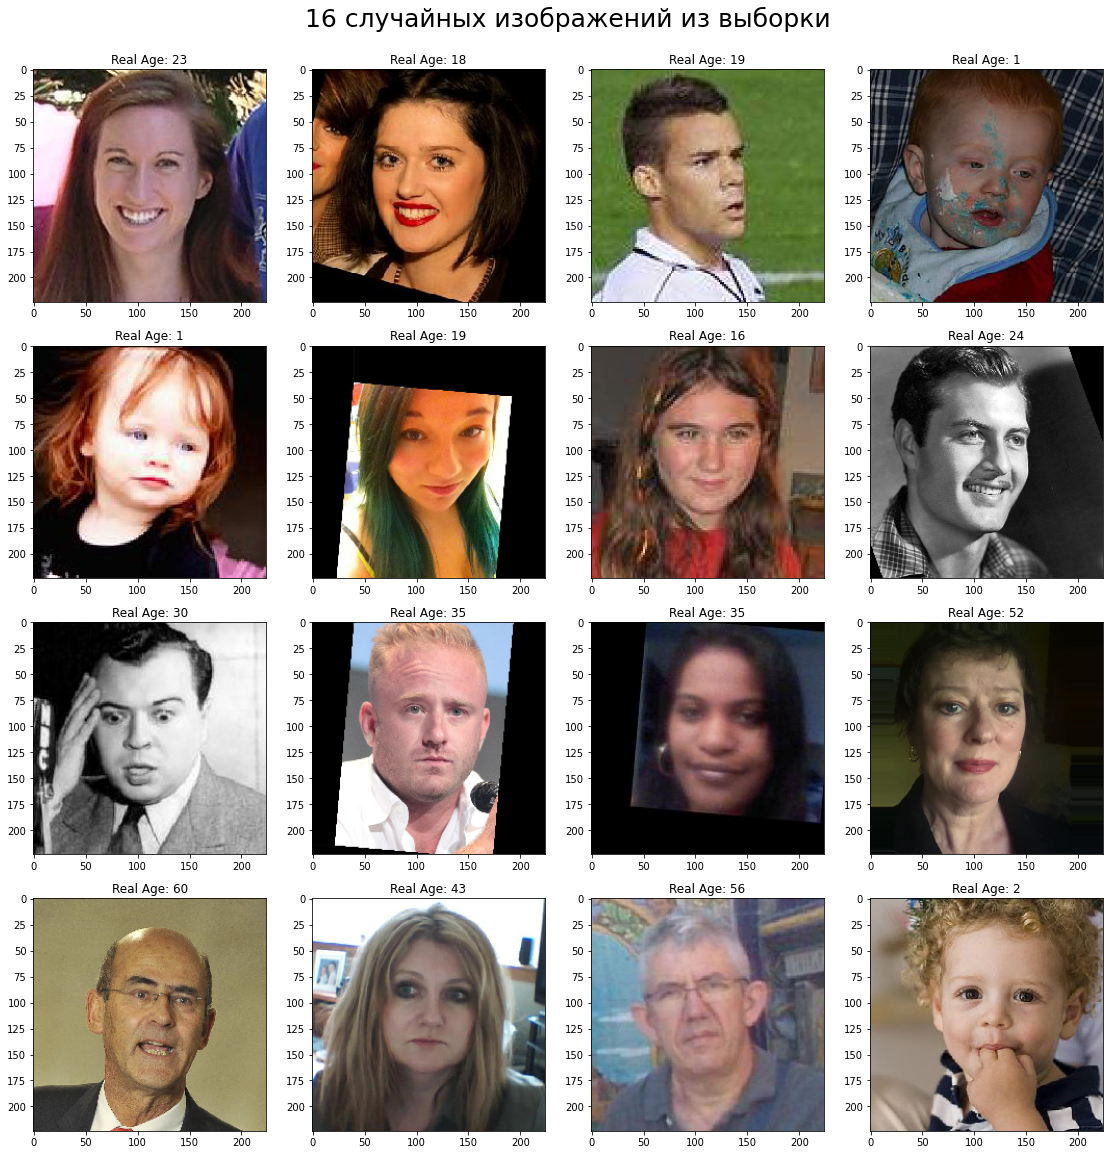

In [10]:
X, y = next(images_gen_flow)

fig = plt.figure(figsize=(16,16))
plt.suptitle('16 случайных изображений из выборки', fontsize=25, x=0.5, y=1)

for i in range(16):
    
    fig.add_subplot(4, 4, i+1)
    plt.title('Real Age: {0}'.format(y[i]))
    plt.imshow(X[i])
    plt.tight_layout()

Загрузили данные и ознакомились с ними. <br>
Файл с разметкой - без пропусков, содержит 2 столбца (Номер фотографии и Реальный возраст человека) и 7591 строку.<br>
То есть в нашем распоряжении фотографии и реальный возраст 7591 человека.<br>
Объем данных, на мой взгляд, не очень велик, но модель будем строить на основе предобученной ResNet50 - посмотрим на результат, может быть ей будет достаточно этой выборки. <br>

Минимальный возраст - 1 год, максимальный - 100 лет. <br>
Среднее значение = 31.2 года, медиана достаточно близка и = 29 годам.<br>
В выборке больше всего человек - 317 с возрастом 30 лет.<br>
В целом по всей выборке больше всего людей в диапазоне 16-30 лет, а наименьшее количество человек в диапазоне 80-100 лет.<br>
И на нашей гистограмме видно, что распределение скошено вправо.<br>
Также на графике видны выбросы в районе "юбилейных" лет - 25, 30, 40, 50, 60, 70, 80, 90 лет.<br>
По всей видимости при разметке, в том случае, если не был известен точный возраст - его округляли до десятков. <br>

Предположу, что для наших целей эти округления не будут страшны:
- для задачи анализа покупок и рекомендации товаров - покупателей все равно будут разбивать на возрастные группы
- на контроль кассиров при продаже алкоголя эти "округления" на должны повлиять, так как они встречаются выше порогового возраста (18 лет)

Количество фотографий совпадает с количеством строк в файле разметки и = 7591 штук.<br>
В основной массе это фотографии лиц крупным планом, очень редко встречаются фото человека в полный рост - что, я думаю, не должно сильно сказаться на итоговом качестве обучаемой нами модели.<br>
Фотографии в основном цветные, но попадаются и черно-белые портреты.<br>
В целом видно, что датасет уже достаточно хорошо предобработан - размеры лиц на фотографиях примерно одинаковые, ориентация выровнена вертикально. 
_______

Приступим к созданию обучающей и валидационной выборок. Настроим и обучим модель.

## Обучение модели

В этом резделе код запускали в отдельном GPU-тренажёре, поэтому оформили его как текстовая ячейка.


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    images_data_gen_train = ImageDataGenerator(horizontal_flip=True, 
                                               rescale=1./255.0,
                                               validation_split=0.25)
    
    train_data = images_data_gen_train.flow_from_dataframe(directory = path + '/final_files/',
                                                           dataframe=labels,
                                                           x_col='file_name', 
                                                           y_col='real_age', 
                                                           target_size= (224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset = 'training',
                                                           seed=424)
    
    return train_data


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    images_data_gen_test = ImageDataGenerator(rescale=1./255.0,
                                              validation_split=0.25)
    
    test_data = images_data_gen_test.flow_from_dataframe(directory = path + '/final_files/',
                                                         dataframe=labels,
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size= (224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset = 'validation',
                                                         seed=424)
        
    return test_data


def create_model(input_shape):
    
    optimizer = Adam(learning_rate=0.0001)
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=500, activation='relu'))
    model.add(Dense(units=250, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    
    return model


Found 5694 validated image filenames.

Found 1897 validated image filenames.


Train for 178 steps, validate for 60 steps

Epoch 1/10

178/178 - 75s - loss: 222.5002 - mae: 10.8661 - val_loss: 622.4264 - val_mae: 19.9770

Epoch 2/10

178/178 - 40s - loss: 69.5919 - mae: 6.3814 - val_loss: 562.9915 - val_mae: 18.6344

Epoch 3/10

178/178 - 40s - loss: 44.9337 - mae: 5.1145 - val_loss: 272.6515 - val_mae: 12.1532

Epoch 4/10

178/178 - 41s - loss: 34.5701 - mae: 4.4409 - val_loss: 174.4138 - val_mae: 10.6443

Epoch 5/10

178/178 - 40s - loss: 23.6431 - mae: 3.7305 - val_loss: 73.9528 - val_mae: 6.5159

Epoch 6/10

178/178 - 41s - loss: 17.3354 - mae: 3.1194 - val_loss: 67.3829 - val_mae: 6.2851

Epoch 7/10

178/178 - 41s - loss: 14.4607 - mae: 2.8837 - val_loss: 73.2820 - val_mae: 6.5843

Epoch 8/10

178/178 - 40s - loss: 13.4191 - mae: 2.7665 - val_loss: 72.8453 - val_mae: 6.2048

Epoch 9/10

178/178 - 40s - loss: 10.4400 - mae: 2.4259 - val_loss: 63.0146 - val_mae: 6.0178

Epoch 10/10

178/178 - 41s - loss: 8.9681 - mae: 2.2481 - val_loss: 67.4545 - val_mae: 6.0834


60/60 - 10s - loss: 67.4545 - mae: 6.0834

Test MAE: 6.0834

_________________________
Мы написали несколько функций:
- создание обучающей выборки
- создание тестовой выборки
- создание модели 
- обучение модели

**Создание обучающей и тестовой выборки** <br>
Функция сгенерировала обучающую выборку (5694 фото) и валидационную выборку (1897 фото).<br>
Валидационная выборка = 25% от общего числа датасета.<br>

**Создание модели**<br>
За костяк нашей модели взяли нейросеть ResNet50 (50 слоев) без верхушки, предобученную на ImageNet.<br>
Добавили к костяку слои:
- 1 слой GlobalAveragePooling2D - пулинг с окном во весь тензор.  
Применяется для усреднения информации по всему изображению. 
- 3 полносвязных слоя Dense с активацией relu:
    - на 500, 250 и 1 нейрон

Так как перед нами стоит задача регрессии - нужно предсказать возраст покупателя, то в функции потерь указали — MSE. <br>
А в качестве оптимизатора выбрали алгоритм Adam со скоростью обучения (learning_rate) = 0.0001

**Обучение модели**<br>
Модель обучали в отдельном GPU-тренажёре, что позволило значительно сократить время обучения.<br>
Для достижения целевого MAE < 7 нам хватило 10 эпох.<br>
**MAE** на валидационной выборке = **6.0834**

## Анализ обученной модели

Обученная нами модель на валидационной выборке показала **MAE** = **6.0834**, то есть она ошибается в своих предсказаниях в среднем на 6 лет.<br>
Данного показателя нам удалось достичь за 10 эпох, обучение одной эпохи происходило за 40-41 секунду.<br>

Таким образом, мы выполнили поставленную перед нами задачу: построили модель, которая по фотографии покупателя способна примерно определить возраст человека. Ошибка предсказания модели менее 7 лет (как того требовало условие).<br>

Вспомним поставленные перед нами задачи:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Если говорить о первой задаче, то наша модель вполне справится с этим.<br>
А вот для второй задачи - контроль добросовестности кассиров при продаже алкоголя - точность нашей модели мала.<br>
6 лет разницы - 18 или 12 ? Это достаточно большой разброс.<br>
В перспективе можно попробовать повысить точность модели, например, добавив в выборку больше людей в возрасте 10-20 лет.
<br>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы